# Exploratory Data Analysis for EOQ Determination

This notebook demonstrates the use of Python to explore a dataset for the prupose of deriving the economic order quantity for a set of products. The `demand_data` file contains the sales of 6 different products, each sold in two different sizes, over a period of two years. The `cost_data` file contains cost information for the two products.

First, we import the libraries that we will be using for the analysis.

In [1]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

import seaborn as sns

%matplotlib inline

Import demand data and save in a `pandas` dataframe object.

In [2]:
demand_data = pd.read_csv('demand_data.csv')

# We can use the `head` function with no additional arguments to print the first five rows of the data.

In [3]:
demand_data.head()

,Product,Pack,Year,Week,Sales
0,A,S,2016,1,101
1,A,S,2016,2,107
2,A,S,2016,3,91
3,A,S,2016,4,103
4,A,S,2016,5,93


# The following cell shows how the `unique` function may be used to see the unique values in a column of the dataframe. Specifically, we use the function to see the unique products.

In [4]:
demand_data['Product'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F'], dtype=object)

# The following cell shows how the groupby function can be used to count the number of entries corresponding to unique combinations of the `Product` and `Pack` columns.

In [5]:
demand_data.groupby(['Product','Pack'])['Sales'].count()

Product  Pack
A        L       104
         S       104
B        L       104
         S       104
C        L       104
         S       104
D        L       104
         S       104
E        L       104
         S       104
F        L       104
         S       104
Name: Sales, dtype: int64

# For the setting we are considering, each unique product/pack combination can be thought of as a *stock keeping unit* (SKU). The following cell uses the data in the `Product` and `Pack` columns to create a new column for SKUs.

In [6]:
demand_data['SKU'] = demand_data['Product'].astype(str) + str('-') +\
demand_data['Pack'].astype(str)

# We can use the `head` function to see that the changes were correctly made.

In [7]:
demand_data.head()

,Product,Pack,Year,Week,Sales,SKU
0,A,S,2016,1,101,A-S
1,A,S,2016,2,107,A-S
2,A,S,2016,3,91,A-S
3,A,S,2016,4,103,A-S
4,A,S,2016,5,93,A-S


# We can store the unique SKUs in an object for later use. The following code block demonstrates this.

In [8]:
SKUs = demand_data['SKU'].unique()
print('The list of SKUs is: {}'.format(SKUs))

The list of SKUs is: ['A-S' 'B-S' 'C-S' 'D-S' 'E-S' 'F-S' 'A-L' 'B-L' 'C-L' 'D-L' 'E-L' 'F-L']


# Although crude, we can use the `plot` function to see if `pandas` can determine a meaningful way to show our data. The following code block uses the plot function to visualize the data for a single SKU.

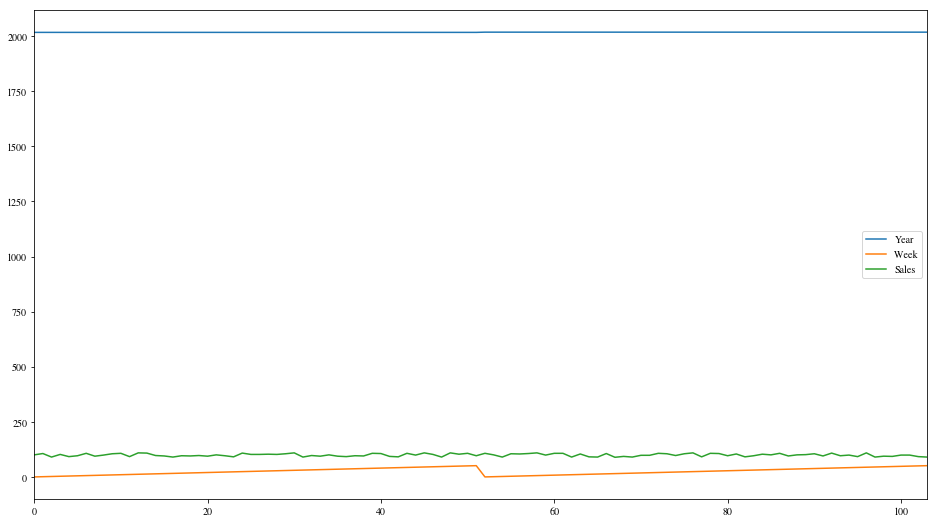

In [9]:
demand_data[demand_data['SKU']=='A-S'].plot(figsize=(16,9))
plt.show()

# The previous graph is not very informative. It would be nice if we have a column in the dataframe that combines the week and year that we can plot by. The next code block shows how to create such a column and set it as the index of the dataframe.

In [10]:
demand_data['Run_Date'] = pd.to_datetime(demand_data.Year.astype(str), format='%Y') +\
pd.to_timedelta(demand_data.Week.mul(7).astype(str) + ' days')

demand_data.set_index('Run_Date',inplace=True)

# The following cell uses the `head` function to print the first 10 rows of the modified dataframe.

In [11]:
demand_data.head(10)

,Product,Pack,Year,Week,Sales,SKU
Run_Date,,,,,,
2016-01-08,A,S,2016,1,101,A-S
2016-01-15,A,S,2016,2,107,A-S
2016-01-22,A,S,2016,3,91,A-S
2016-01-29,A,S,2016,4,103,A-S
2016-02-05,A,S,2016,5,93,A-S
2016-02-12,A,S,2016,6,97,A-S
2016-02-19,A,S,2016,7,108,A-S
2016-02-26,A,S,2016,8,95,A-S
2016-03-04,A,S,2016,9,100,A-S


# Plotting Data - We can use the transformed dataframe to create a more informative plot.

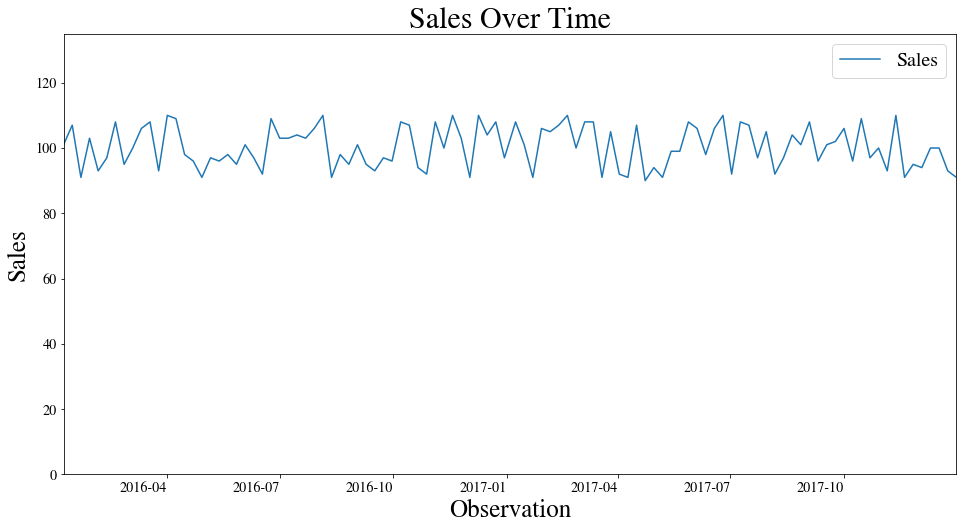

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))
demand_data[demand_data['SKU']=='A-S']['Sales'].plot(figsize=(16,9),ax=ax)
plt.setp(ax.get_xticklabels(), rotation=0, fontsize=14)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_title('Sales Over Time',size=30)
ax.set_xlabel('Observation',size=25)
ax.set_ylabel('Sales',size=25)
ax.set_ylim([0,max(demand_data[demand_data['SKU']=='A-S']['Sales'])+25])
ax.legend(fontsize = 20)
plt.show()

# The following cell reads the `cost_data` file and stores the data in a `pandas` dataframe object.

In [13]:
cost_data = pd.read_csv('cost_data.csv')

# We print the first 5 rows for verification. Doing this, we see that we will need to transform the data to indicate the SKU as we did previously.

In [14]:
cost_data.head()

,Product,Pack,Unit Cost,Holding Cost Rate (Annual),Order Cost
0,A,S,10.00,0.20,25
1,B,S,12.00,0.22,25
2,C,S,15.00,0.30,25
3,D,S,11.00,0.21,25
4,E,S,8.00,0.39,25


# The following code block creates the `SKU` column, sets the `SKU` column as the *index* of the dataframe, and renames the *Holding Cost Rate (Annual)* column to something easier to recall and type.

In [15]:
cost_data['SKU'] = cost_data['Product'].astype(str) + str('-')+\
cost_data['Pack'].astype(str)
cost_data.set_index('SKU',inplace=True)
cost_data.rename(columns = {'Holding Cost Rate (Annual)':'HC_Rate'},inplace = True) 

The *Economic Order Quantity* ($EOQ$) is determined by finding the cost where the derivative of the total annual cost curve equals zero. The total annual cost of ordering $Q$ units (under the $EOQ$ assumptions) is given by:
$$c_{r}\left(\frac{A}{Q}\right)+c_{h}\left(\frac{Q}{2}\right)+c_{u}A,$$
where $A$ denotes the annual demand, $c_{r}$ denotes the reorder cost, $c_{h}$ denotes the holding cost ($\$/unit/year$), and $c_{u}$ denotes the unit cost. As seen in class, the EOQ is given by: 

$$EOQ = \sqrt{\frac{2Ac_{r}}{c_{h}}}.$$

The following code block defines a function that we can call to calculate the EOQ for a given set of inputs.

In [16]:
def EOQ(Annual_Demand, HC_Rate, Unit_Cost, Reorder_Cost):
    Holding_Cost = HC_Rate * Unit_Cost
    EOQ = np.sqrt((2*Annual_Demand*Reorder_Cost)/Holding_Cost)
    return EOQ

# The following code block shows how we can use the previously defined function to calculate the EOQ for a single SKU. **Note that we are using the mean weekly demand times the number of weeks in a year as an approximation for annual demand**.

In [17]:
current_sku = 'A-S'

A = demand_data[demand_data['SKU']==current_sku]['Sales'].mean() * 52
i = cost_data.loc[current_sku,'HC_Rate']
UC = cost_data.loc[current_sku,'Unit Cost']
RC = cost_data.loc[current_sku,'Order Cost']

print('The EOQ for SKU {} is {} units'.format(current_sku,round(EOQ(A,i,UC,RC),2)))

The EOQ for SKU A-S is 361.14 units


# The following cell shows how we can use a `for` loop, along with our previously created list of SKUs, to calculate the EOQ for all SKUs.

In [18]:
for current_sku in SKUs:
    current_sku = current_sku

    A = demand_data[demand_data['SKU']==current_sku]['Sales'].mean() * 52
    i = cost_data.loc[current_sku,'HC_Rate']
    UC = cost_data.loc[current_sku,'Unit Cost']
    RC = cost_data.loc[current_sku,'Order Cost']

    print('The EOQ for SKU {} is {} units'.format(current_sku,round(EOQ(A,i,UC,RC),2)))

The EOQ for SKU A-S is 361.14 units
The EOQ for SKU B-S is 307.51 units
The EOQ for SKU C-S is 168.98 units
The EOQ for SKU D-S is 211.47 units
The EOQ for SKU E-S is 257.84 units
The EOQ for SKU F-S is 374.71 units
The EOQ for SKU A-L is 193.52 units
The EOQ for SKU B-L is 255.28 units
The EOQ for SKU C-L is 249.61 units
The EOQ for SKU D-L is 157.74 units
The EOQ for SKU E-L is 167.9 units
The EOQ for SKU F-L is 296.5 units


# Plotting Data - Now, if we were naive, we may believe that our job is done. However, implementing the EOQs derived in the previous cell would be a mistake. To see why, let's plot the sales for the "B-S" SKU.

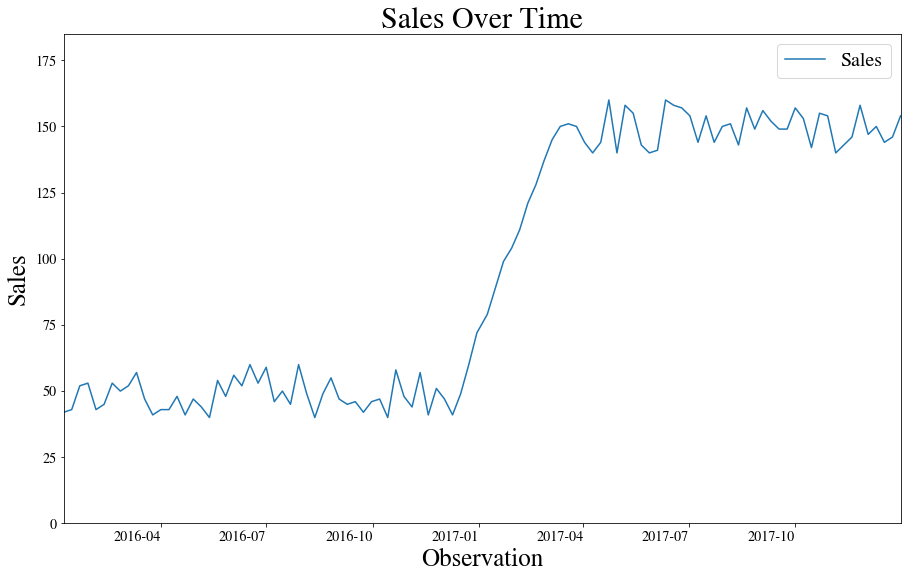

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (15,10))
demand_data[demand_data['SKU']=='B-S']['Sales'].plot(ax=ax)
plt.setp(ax.get_xticklabels(), rotation=0, fontsize=14)
plt.setp(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_title('Sales Over Time',size=30)
ax.set_xlabel('Observation',size=25)
ax.set_ylabel('Sales',size=25)
ax.set_ylim([0,max(demand_data[demand_data['SKU']=='B-S']['Sales'])+25])
ax.legend(fontsize = 20)
plt.show()

# Plotting All product demands - Noting the shift observed for the "B-S" SKU, it would be advisable to plot the data for all SKUs. The following code block uses a `for` loop to do this.

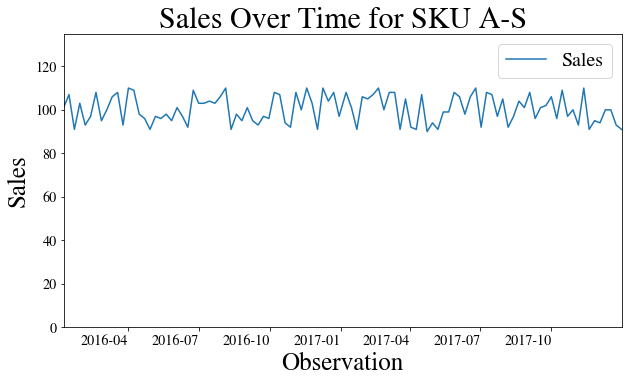

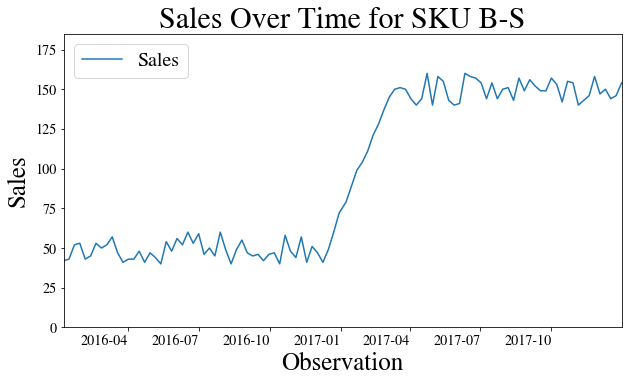

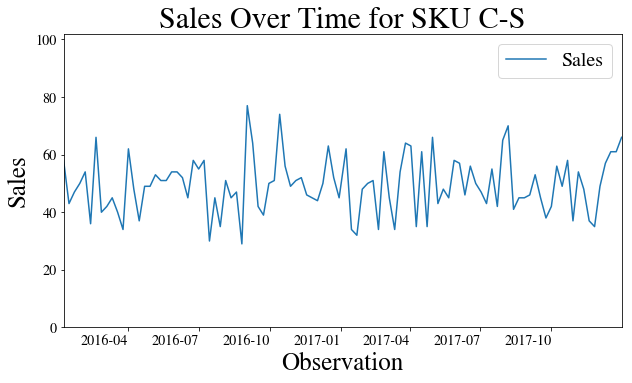

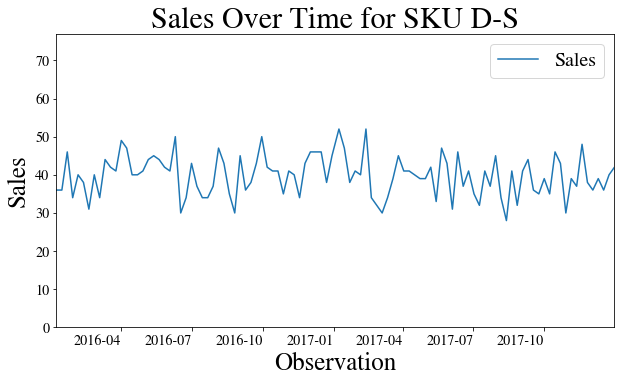

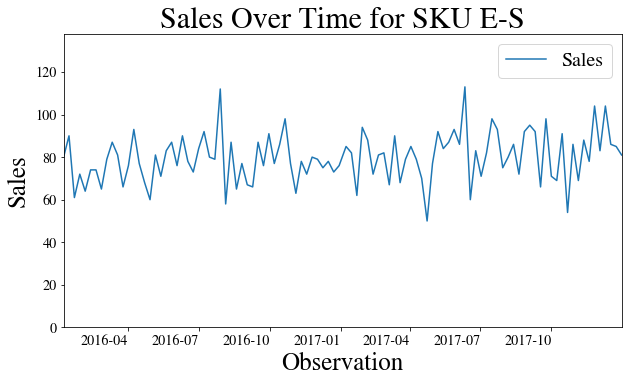

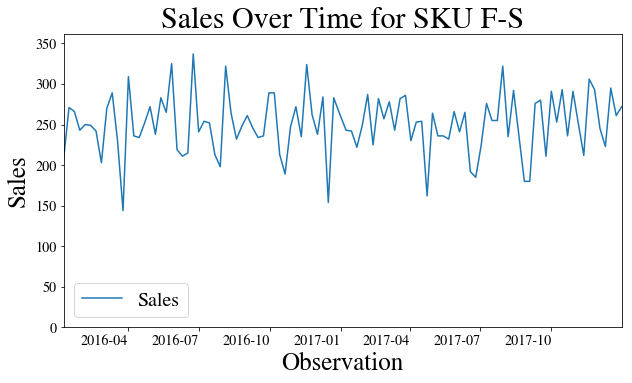

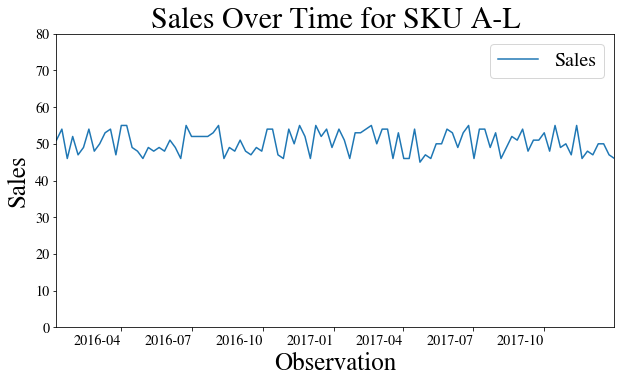

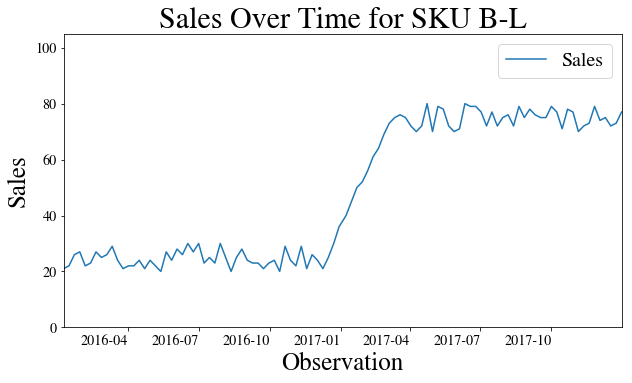

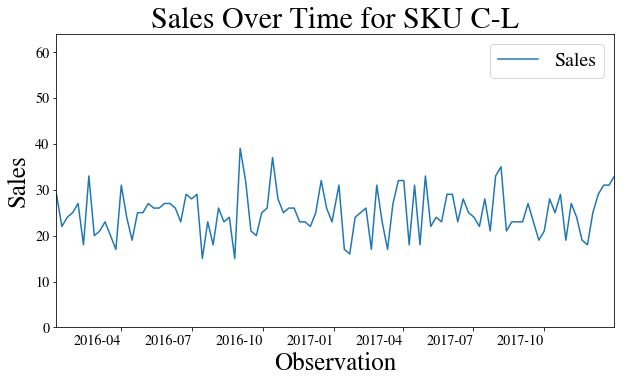

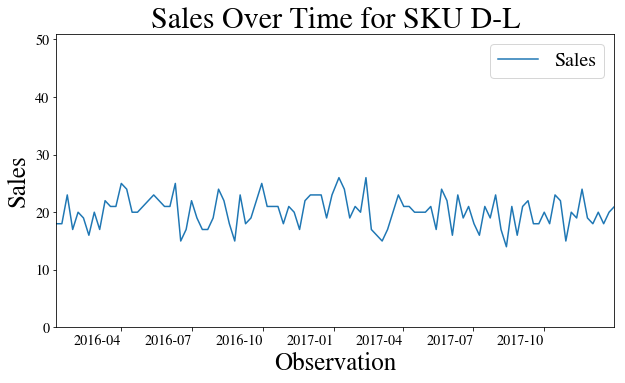

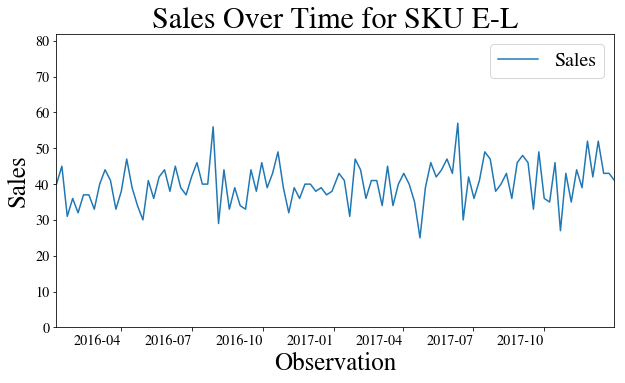

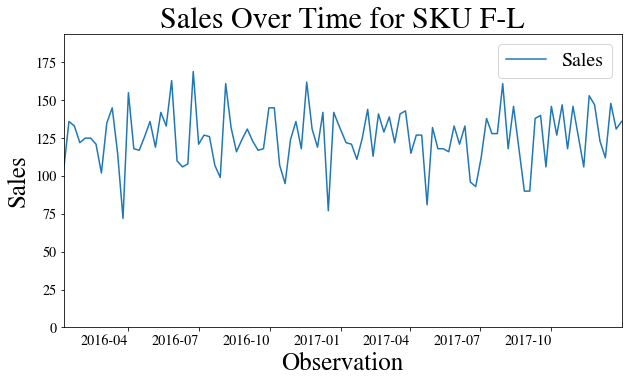

In [20]:
for current_sku in SKUs:
    fig, ax = plt.subplots(1, 1, figsize = (10,6))
    demand_data[demand_data['SKU']==current_sku]['Sales'].plot(ax=ax)
    plt.setp(ax.get_xticklabels(), rotation=0, fontsize=14)
    plt.setp(ax.get_yticklabels(), rotation=0, fontsize=14)
    ax.set_title('Sales Over Time for SKU {}'.format(current_sku),size=30)
    ax.set_xlabel('Observation',size=25)
    ax.set_ylabel('Sales',size=25)
    ax.set_ylim([0,max(demand_data[demand_data['SKU']==current_sku]['Sales'])+25])
    ax.legend(fontsize = 20)
    plt.show()

# The previous plots suggest that instead of using all of the sales data to approximate the annual demand, it will be more accurate to use the most recent sales data. The following code block introduces the `tail` function, which allows us to take the last rows of data for a speified SKU.

In [21]:
demand_data[demand_data['SKU']=='B-S'].tail(60)

,Product,Pack,Year,Week,Sales,SKU
Run_Date,,,,,,
2016-11-11,B,S,2016,45,57,B-S
2016-11-18,B,S,2016,46,41,B-S
2016-11-25,B,S,2016,47,51,B-S
2016-12-02,B,S,2016,48,47,B-S
2016-12-09,B,S,2016,49,41,B-S
2016-12-16,B,S,2016,50,49,B-S
2016-12-23,B,S,2016,51,60,B-S
2016-12-30,B,S,2016,52,72,B-S
2017-01-08,B,S,2017,1,79,B-S


# The following code block includes a modified version of the `for` loop we used to determine the EOQ for the various SKUs, with the last 25 periods being used to approximate annual demand.

In [22]:
for current_sku in SKUs:
    current_sku = current_sku

    A = demand_data[demand_data['SKU']==current_sku]['Sales'].tail(25).mean() * 52
    i = cost_data.loc[current_sku,'HC_Rate']
    UC = cost_data.loc[current_sku,'Unit Cost']
    RC = cost_data.loc[current_sku,'Order Cost']

    print('The EOQ for SKU {} is {} units'.format(current_sku,round(EOQ(A,i,UC,RC),2)))

The EOQ for SKU A-S is 359.47 units
The EOQ for SKU B-S is 383.99 units
The EOQ for SKU C-S is 170.31 units
The EOQ for SKU D-S is 208.11 units
The EOQ for SKU E-S is 264.32 units
The EOQ for SKU F-S is 380.05 units
The EOQ for SKU A-L is 192.65 units
The EOQ for SKU B-L is 318.44 units
The EOQ for SKU C-L is 251.79 units
The EOQ for SKU D-L is 155.3 units
The EOQ for SKU E-L is 172.04 units
The EOQ for SKU F-L is 300.76 units
